# SC4002 Natural Language Processing Assignment

**Group:** 35

**Group Members:**
- Lim Xin Wei
- Pearlina Tan Qinlin
- Lim Jia Jie, Isaac
- Jefferson Ho Qi Yong
- Tay Wei Yang

## Installation and Setup

In [1]:
# Install required packages
!pip install torchtext==0.4.0 -q
!pip install spacy -q
!python -m spacy download en_core_web_sm -q
!pip install gensim scikit-learn matplotlib seaborn -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data, datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from collections import Counter, defaultdict
import gensim.downloader as api
import spacy
import random
import warnings
warnings.filterwarnings('ignore')

# Set seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Part 0: Dataset Preparation

In [3]:
# Load TREC dataset
TEXT = data.Field(tokenize='spacy',
                  tokenizer_language='en_core_web_sm',
                  include_lengths=True,
                  lower=True)

LABEL = data.LabelField()

train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

print("Example:", vars(train_data.examples[0]))
print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

downloading train_5500.label


train_5500.label: 100%|██████████| 336k/336k [00:00<00:00, 366kB/s]  


downloading TREC_10.label


TREC_10.label: 100%|██████████| 23.4k/23.4k [00:00<00:00, 93.3kB/s]


Example: {'text': ['how', 'did', 'serfdom', 'develop', 'in', 'and', 'then', 'leave', 'russia', '?'], 'label': 'DESC'}
Training samples: 5452
Test samples: 500


In [4]:
# Split into train and validation
train_data, valid_data = train_data.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f"Training: {len(train_data)}")
print(f"Validation: {len(valid_data)}")
print(f"Test: {len(test_data)}")

Training: 4362
Validation: 1090
Test: 500


In [5]:
# Build vocabulary
TEXT.build_vocab(train_data, min_freq=1)
LABEL.build_vocab(train_data)

print(f"Vocabulary size: {len(TEXT.vocab)}")
print(f"Number of classes: {len(LABEL.vocab)}")
print(f"Labels: {LABEL.vocab.stoi}")

Vocabulary size: 7435
Number of classes: 6
Labels: defaultdict(None, {'HUM': 0, 'ENTY': 1, 'DESC': 2, 'NUM': 3, 'LOC': 4, 'ABBR': 5})


## Part 1: Preparing Word Embeddings

In [6]:
glove = api.load('glove-wiki-gigaword-300')
embedding_dim = 300
print(f"Embedding dimension: {embedding_dim}")

Embedding dimension: 300


### Question 1(a): Vocabulary Size

In [7]:
vocab_size = len(TEXT.vocab)
print(f"Answer: Vocabulary size = {vocab_size}")

Answer: Vocabulary size = 7435


### Question 1(b): OOV Words Analysis

In [8]:
# Find OOV words
oov_words = []
for word in TEXT.vocab.itos:
    if word not in glove:
        oov_words.append(word)

print(f"Total OOV words: {len(oov_words)}")
print(f"Percentage: {len(oov_words)/vocab_size*100:.2f}%")
print(f"Sample OOV words: {oov_words[:20]}")

Total OOV words: 192
Percentage: 2.58%
Sample OOV words: ['<unk>', '<pad>', '..', 'cotrubas', '2th', 'daminozide', 'dextropropoxyphen', 'indiglo', 'napsylate', 'vbp', '-lantern', '.com', '.dbf', '.tbk', '10-', '12601', '187s', '36893', '37803', '45mhz']


In [9]:
# OOV per topic
oov_per_topic = defaultdict(set)

for example in train_data.examples:
    label = example.label
    for word in example.text:
        if word not in glove:
            oov_per_topic[label].add(word)

print("OOV words per topic:")
for topic, words in sorted(oov_per_topic.items()):
    print(f"{topic}: {len(words)} unique OOV words")

OOV words per topic:
ABBR: 4 unique OOV words
DESC: 68 unique OOV words
ENTY: 47 unique OOV words
HUM: 39 unique OOV words
LOC: 15 unique OOV words
NUM: 21 unique OOV words


### Question 1(c): OOV Mitigation Strategy

In [10]:
def create_embedding_matrix_with_oov_handling(vocab, glove_model, embedding_dim):
    vocab_size = len(vocab)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    oov_count = 0

    for idx, word in enumerate(vocab.itos):
        if word == '<pad>':
            embedding_matrix[idx] = np.zeros(embedding_dim)
        elif word in glove_model:
            embedding_matrix[idx] = glove_model[word]
        else:
            oov_count += 1
            similar_embeddings = []

            # Character n-grams
            if len(word) > 3:
                for i in range(len(word) - 2):
                    trigram = word[i:i+3]
                    if trigram in glove_model:
                        similar_embeddings.append(glove_model[trigram])

            # Remove special characters
            cleaned_word = ''.join(c for c in word if c.isalnum())
            if cleaned_word and cleaned_word in glove_model:
                similar_embeddings.append(glove_model[cleaned_word])

            # Lowercase
            if word.lower() in glove_model:
                similar_embeddings.append(glove_model[word.lower()])

            if similar_embeddings:
                embedding_matrix[idx] = np.mean(similar_embeddings, axis=0)
            else:
                embedding_matrix[idx] = np.random.normal(0, 0.1, embedding_dim)

    print(f"OOV words handled: {oov_count}")
    return embedding_matrix

embedding_matrix = create_embedding_matrix_with_oov_handling(TEXT.vocab, glove, embedding_dim)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

OOV words handled: 191
Embedding matrix shape: (7435, 300)


### Question 1(d): Word Embedding Visualization

In [11]:
# Get top words per topic
nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words

topic_word_counts = defaultdict(Counter)

for example in train_data.examples:
    label = example.label
    for word in example.text:
        if word not in stopwords and word in glove:
            topic_word_counts[label][word] += 1

all_words = []
all_labels = []
all_embeddings = []

for topic, word_counts in topic_word_counts.items():
    top_words = [word for word, count in word_counts.most_common(20)]
    for word in top_words:
        all_words.append(word)
        all_labels.append(topic)
        all_embeddings.append(glove[word])

print(f"Total words for visualization: {len(all_words)}")

Total words for visualization: 120


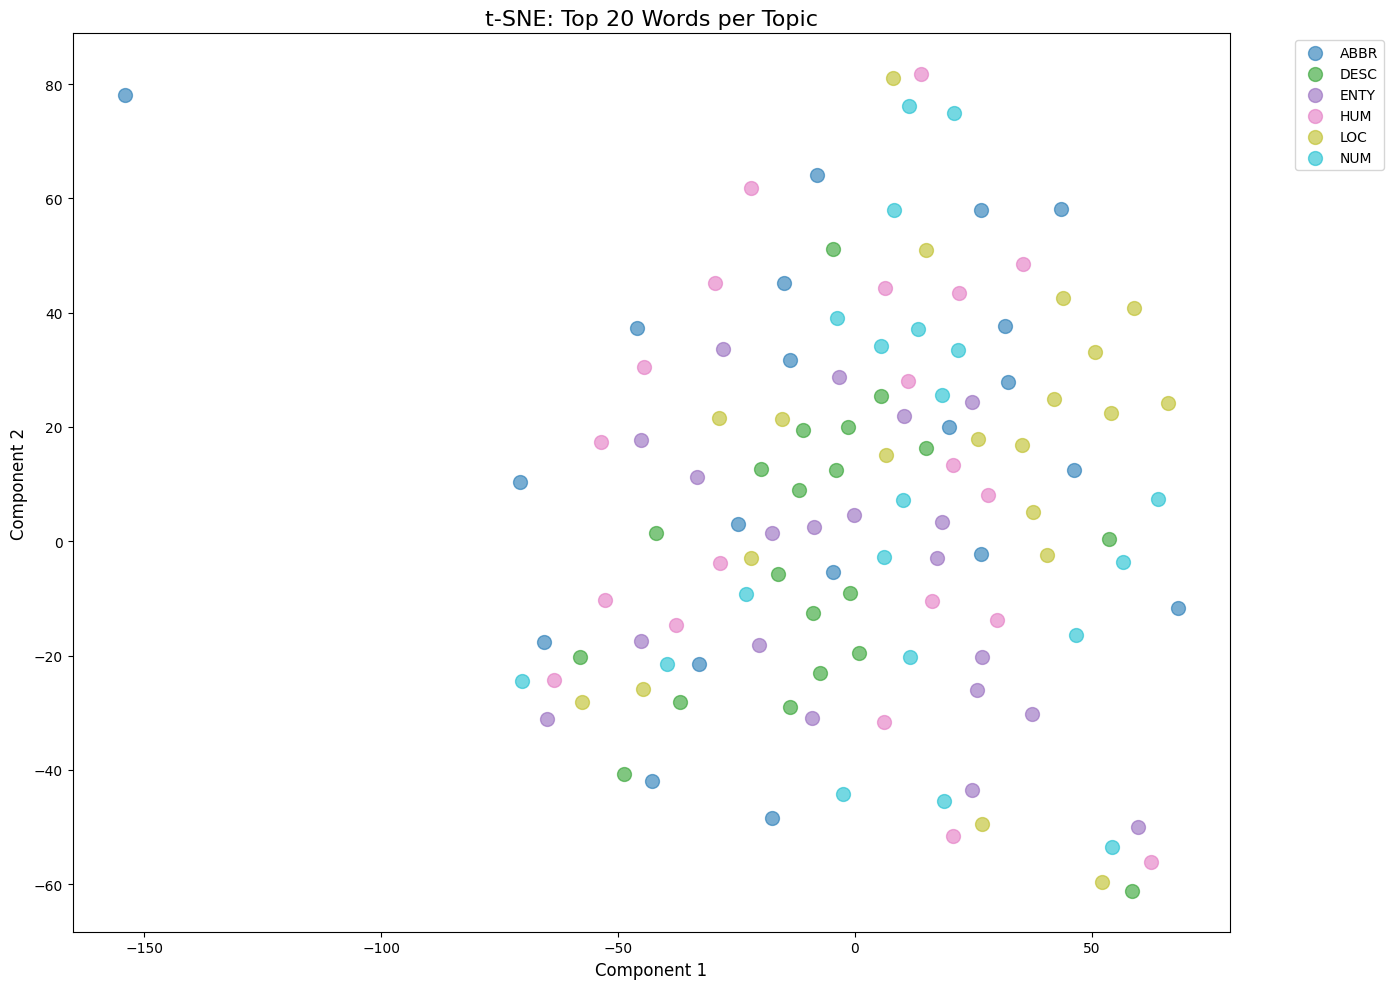

In [12]:
# t-SNE visualization
embeddings_array = np.array(all_embeddings)
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_array)

plt.figure(figsize=(14, 10))
unique_labels = sorted(set(all_labels))
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}

for label in unique_labels:
    indices = [i for i, l in enumerate(all_labels) if l == label]
    plt.scatter(embeddings_2d[indices, 0],
               embeddings_2d[indices, 1],
               c=[label_to_color[label]],
               label=label,
               alpha=0.6,
               s=100)

plt.title('t-SNE: Top 20 Words per Topic', fontsize=16)
plt.xlabel('Component 1', fontsize=12)
plt.ylabel('Component 2', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('word_embeddings_viz.png', dpi=300, bbox_inches='tight')
plt.show()

## Part 2: RNN Model Training

In [13]:
# Create iterators
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    device=device
)

print(f"Batches - Train: {len(train_iterator)}, Valid: {len(valid_iterator)}, Test: {len(test_iterator)}")

Batches - Train: 69, Valid: 18, Test: 8


In [14]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 n_layers, bidirectional, dropout, embedding_matrix, aggregation='last'):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))

        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers,
                         bidirectional=bidirectional,
                         dropout=dropout if n_layers > 1 else 0,
                         batch_first=False)

        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.aggregation = aggregation
        self.bidirectional = bidirectional

    def forward(self, text, text_lengths):

        embedded = self.dropout(self.embedding(text))  # [seq_len, batch, emb_dim]

        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), enforce_sorted=False
        )

        # Pass through RNN
        packed_out, hidden = self.rnn(packed)

        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_out)
        # output is seq_len, batch, hidden_dim * num_directions

        # Aggregate hidden states
        if self.aggregation == 'last':
            if self.bidirectional:
                # Concatenate final forward and backward hidden states
                hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
            else:
                hidden = hidden[-1,:,:]
            sentence_repr = hidden
        elif self.aggregation == 'mean':
            # Mean pooling - [batch, seq_len, hidden]
            output = output.permute(1, 0, 2)
            lengths_expanded = text_lengths.unsqueeze(1).float()
            sentence_repr = torch.sum(output, dim=1) / lengths_expanded
        elif self.aggregation == 'max':
            # Max pooling - [batch, seq_len, hidden]
            output = output.permute(1, 0, 2)
            sentence_repr, _ = torch.max(output, dim=1)
        else:
            raise ValueError(f"Unknown aggregation method: {self.aggregation}")

        sentence_repr = self.dropout(sentence_repr)
        return self.fc(sentence_repr)

In [15]:
# Training functions
def calculate_accuracy(preds, y):
    top_pred = preds.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    return correct.float() / y.shape[0]

def train_epoch(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.text
        predictions = model(text, text_lengths)

        loss = criterion(predictions, batch.label)
        acc = calculate_accuracy(predictions, batch.label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths)

            loss = criterion(predictions, batch.label)
            acc = calculate_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_topic_wise(model, iterator, label_vocab):
    model.eval()
    topic_correct = defaultdict(int)
    topic_total = defaultdict(int)

    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths)
            top_pred = predictions.argmax(1)

            for pred, true in zip(top_pred, batch.label):
                true_label = label_vocab.itos[true.item()]
                topic_total[true_label] += 1
                if pred.item() == true.item():
                    topic_correct[true_label] += 1

    return {topic: topic_correct[topic] / topic_total[topic] for topic in topic_total}

### Question 2(b): Testing Regularization Strategies

In [45]:
# Configuration
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = len(LABEL.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
LEARNING_RATE = 0.001
N_EPOCHS = 20
PATIENCE = 5

regularization_results = {}

In [46]:
# Test 1: No regularization
print("No Regularization")
model = RNNClassifier(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                      N_LAYERS, BIDIRECTIONAL, dropout=0.0,
                      embedding_matrix=embedding_matrix).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

best_valid_acc = 0
patience_counter = 0

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'rnn_no_reg.pt')
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        break

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Train Acc={train_acc:.3f}, Valid Acc={valid_acc:.3f}")

model.load_state_dict(torch.load('rnn_no_reg.pt'))
_, test_acc = evaluate(model, test_iterator, criterion)
regularization_results['No Regularization'] = test_acc
print(f"Test Accuracy: {test_acc:.4f}\n")

No Regularization
Epoch 5: Train Acc=0.991, Valid Acc=0.835
Epoch 10: Train Acc=1.000, Valid Acc=0.845
Epoch 15: Train Acc=1.000, Valid Acc=0.845
Test Accuracy: 0.8899



In [47]:
# Test 2: Dropout
print("Dropout (0.5)")
model = RNNClassifier(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                      N_LAYERS, BIDIRECTIONAL, dropout=0.5,
                      embedding_matrix=embedding_matrix).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

best_valid_acc = 0
patience_counter = 0

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'rnn_dropout.pt')
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        break

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Train Acc={train_acc:.3f}, Valid Acc={valid_acc:.3f}")

model.load_state_dict(torch.load('rnn_dropout.pt'))
_, test_acc = evaluate(model, test_iterator, criterion)
regularization_results['Dropout (0.5)'] = test_acc
print(f"Test Accuracy: {test_acc:.4f}\n")

Dropout (0.5)
Epoch 5: Train Acc=0.881, Valid Acc=0.791
Epoch 10: Train Acc=0.945, Valid Acc=0.832
Epoch 15: Train Acc=0.970, Valid Acc=0.860
Test Accuracy: 0.8948



In [48]:
# Test 3: L2 Regularization
print("L2")
model = RNNClassifier(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                      N_LAYERS, BIDIRECTIONAL, dropout=0.3,
                      embedding_matrix=embedding_matrix).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

best_valid_acc = 0
patience_counter = 0

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'rnn_l2.pt')
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        break

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Train Acc={train_acc:.3f}, Valid Acc={valid_acc:.3f}")

model.load_state_dict(torch.load('rnn_l2.pt'))
_, test_acc = evaluate(model, test_iterator, criterion)
regularization_results['L2 Regularization'] = test_acc
print(f"Test Accuracy: {test_acc:.4f}\n")

L2
Epoch 5: Train Acc=0.932, Valid Acc=0.797
Epoch 10: Train Acc=0.975, Valid Acc=0.841
Test Accuracy: 0.8992



In [70]:
# Test 4: Dropout + L2 (Best)
print("Dropout + L2")
model = RNNClassifier(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                      N_LAYERS, BIDIRECTIONAL, dropout=0.5,
                      embedding_matrix=embedding_matrix).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

best_valid_acc = 0
patience_counter = 0
train_losses_best = []
valid_accs_best = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_losses_best.append(train_loss)
    valid_accs_best.append(valid_acc)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'rnn_best.pt')
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        break

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Train Acc={train_acc:.3f}, Valid Acc={valid_acc:.3f}")

model.load_state_dict(torch.load('rnn_best.pt'))
_, test_acc = evaluate(model, test_iterator, criterion)
regularization_results['Dropout + L2'] = test_acc
print(f"Test Accuracy: {test_acc:.4f}\n")

best_rnn_model = model

Dropout + L2


Epoch 5: Train Acc=0.871, Valid Acc=0.818
Epoch 10: Train Acc=0.945, Valid Acc=0.829
Epoch 15: Train Acc=0.971, Valid Acc=0.837
Test Accuracy: 0.9153



In [71]:
# Summary
for strategy, acc in regularization_results.items():
    print(f"{strategy:30s}: {acc:.4f}")

No Regularization             : 0.8899
Dropout (0.5)                 : 0.8948
L2 Regularization             : 0.8992
Dropout + L2                  : 0.9153


### Question 2(a): Best Model Configuration

In [51]:
print("Model configuration:")
print(f"Training Epochs: {len(train_losses_best)}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Optimizer: Adam")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Hidden Dimension: {HIDDEN_DIM}")
print(f"Number of Layers: {N_LAYERS}")
print(f"Bidirectional: {BIDIRECTIONAL}")
print(f"Dropout: 0.5")
print(f"Weight Decay: 1e-4")

Model configuration:
Training Epochs: 20
Learning Rate: 0.001
Optimizer: Adam
Batch Size: 64
Hidden Dimension: 256
Number of Layers: 2
Bidirectional: True
Dropout: 0.5
Weight Decay: 1e-4


### Question 2(c): Training Curves

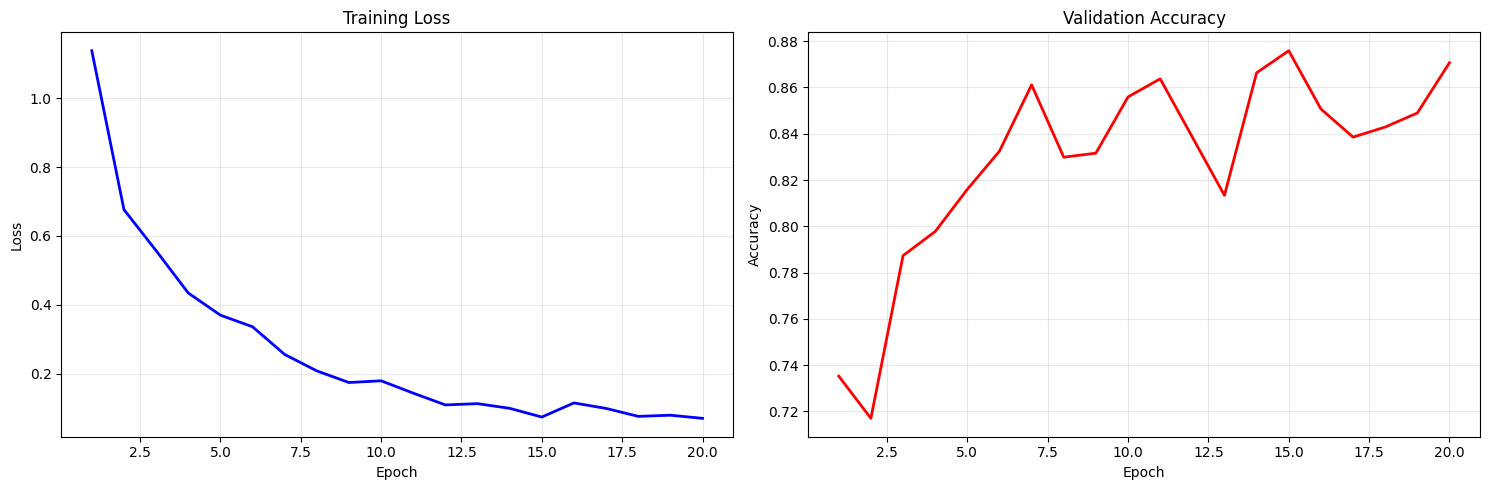

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(range(1, len(train_losses_best)+1), train_losses_best, 'b-', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, len(valid_accs_best)+1), valid_accs_best, 'r-', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rnn_curves.png', dpi=300)
plt.show()


### Question 2(d): Aggregation Strategies

In [53]:
aggregation_results = {}

for agg_method in ['last', 'mean', 'max']:
    print(f"\ttest: {agg_method.upper()}")

    model = RNNClassifier(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                          N_LAYERS, BIDIRECTIONAL, dropout=0.5,
                          embedding_matrix=embedding_matrix,
                          aggregation=agg_method).to(device)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    best_valid_acc = 0
    patience_counter = 0

    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            patience_counter = 0
            torch.save(model.state_dict(), f'rnn_{agg_method}.pt')
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            break

    model.load_state_dict(torch.load(f'rnn_{agg_method}.pt'))
    _, test_acc = evaluate(model, test_iterator, criterion)
    aggregation_results[agg_method] = test_acc
    print(f"Test Accuracy: {test_acc:.4f}")

print("\naggregation comparison:")
for method, acc in aggregation_results.items():
    print(f"{method.upper():10s}: {acc:.4f}")

	test: LAST
Test Accuracy: 0.9142
	test: MEAN
Test Accuracy: 0.8875
	test: MAX
Test Accuracy: 0.9114

aggregation comparison:
LAST      : 0.9142
MEAN      : 0.8875
MAX       : 0.9114


### Question 2(e): Topic-wise Accuracy

topic wise accuracy:
ABBR           : 0.7778
ENTY           : 0.8298
LOC            : 0.8519
NUM            : 0.8850
HUM            : 0.9077
DESC           : 0.9710


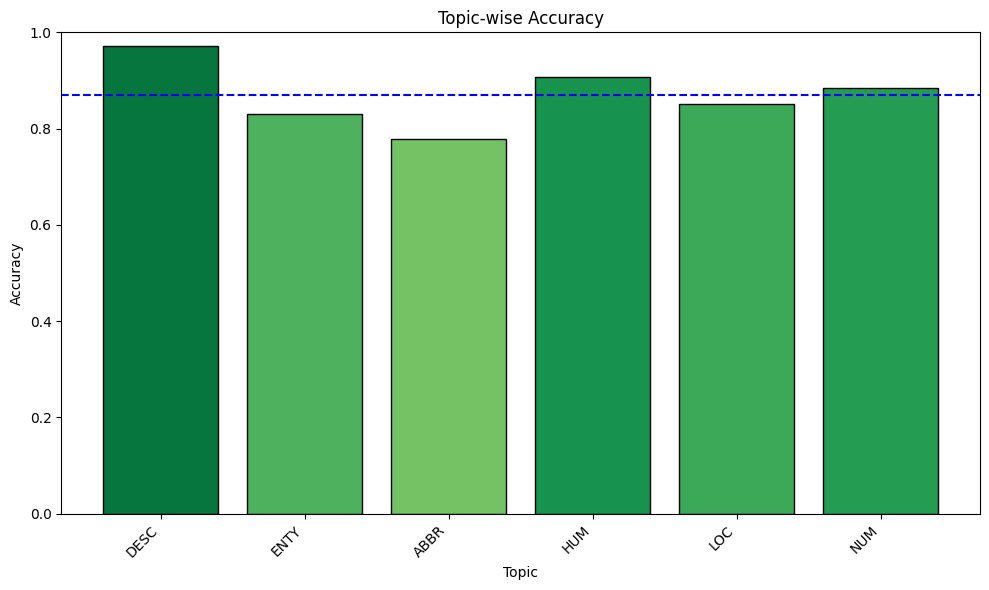

In [54]:
best_rnn_model.load_state_dict(torch.load('rnn_best.pt'))
topic_accuracy_rnn = evaluate_topic_wise(best_rnn_model, test_iterator, LABEL.vocab)

print("topic wise accuracy:")
for topic, acc in sorted(topic_accuracy_rnn.items(), key=lambda x: x[1]):
    print(f"{topic:15s}: {acc:.4f}")

# Visualize
plt.figure(figsize=(10, 6))
topics = list(topic_accuracy_rnn.keys())
accuracies = [topic_accuracy_rnn[t] for t in topics]
colors = plt.cm.RdYlGn(np.array(accuracies))

plt.bar(topics, accuracies, color=colors, edgecolor='black')
plt.xlabel('Topic')
plt.ylabel('Accuracy')
plt.title('Topic-wise Accuracy')
plt.ylim([0, 1.0])
plt.xticks(rotation=45, ha='right')
plt.axhline(y=np.mean(accuracies), color='blue', linestyle='--')
plt.tight_layout()
plt.savefig('topic_accuracy.png', dpi=300)
plt.show()

## Part 3: Enhancements

### Part 3.1: BiLSTM and BiGRU

In [55]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 n_layers, dropout, embedding_matrix):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                           bidirectional=True, dropout=dropout if n_layers > 1 else 0,
                           batch_first=False)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        # text is [seq_len, batch_size] from torchtext
        embedded = self.dropout(self.embedding(text))

        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), enforce_sorted=False
        )

        _, (hidden, _) = self.lstm(packed)

        # Concatenate final forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.dropout(hidden)

        return self.fc(hidden)


class BiGRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
                 n_layers, dropout, embedding_matrix):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))

        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers,
                         bidirectional=True, dropout=dropout if n_layers > 1 else 0,
                         batch_first=False)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        # text is [seq_len, batch_size] from torchtext
        embedded = self.dropout(self.embedding(text))

        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), enforce_sorted=False
        )

        _, hidden = self.gru(packed)

        # Concatenate final forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.dropout(hidden)

        return self.fc(hidden)

In [56]:
# BiLSTM
bilstm = BiLSTMClassifier(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                          N_LAYERS, dropout=0.5, embedding_matrix=embedding_matrix).to(device)

optimizer = optim.Adam(bilstm.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

best_valid_acc = 0
patience_counter = 0
train_losses_bilstm = []
valid_accs_bilstm = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_epoch(bilstm, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(bilstm, valid_iterator, criterion)

    train_losses_bilstm.append(train_loss)
    valid_accs_bilstm.append(valid_acc)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        patience_counter = 0
        torch.save(bilstm.state_dict(), 'bilstm.pt')
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        break

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Valid Acc={valid_acc:.3f}")

bilstm.load_state_dict(torch.load('bilstm.pt'))
_, test_acc_bilstm = evaluate(bilstm, test_iterator, criterion)
print(f"BiLSTM Test Accuracy: {test_acc_bilstm:.4f}\n")

Epoch 5: Valid Acc=0.878
BiLSTM Test Accuracy: 0.8894



In [57]:
# BiGRU
bigru = BiGRUClassifier(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                        N_LAYERS, dropout=0.5, embedding_matrix=embedding_matrix).to(device)

optimizer = optim.Adam(bigru.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

best_valid_acc = 0
patience_counter = 0
train_losses_bigru = []
valid_accs_bigru = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_epoch(bigru, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(bigru, valid_iterator, criterion)

    train_losses_bigru.append(train_loss)
    valid_accs_bigru.append(valid_acc)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        patience_counter = 0
        torch.save(bigru.state_dict(), 'bigru.pt')
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        break

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Valid Acc={valid_acc:.3f}")

bigru.load_state_dict(torch.load('bigru.pt'))
_, test_acc_bigru = evaluate(bigru, test_iterator, criterion)
print(f"BiGRU Test Accuracy: {test_acc_bigru:.4f}\n")

Epoch 5: Valid Acc=0.867
Epoch 10: Valid Acc=0.881
BiGRU Test Accuracy: 0.9055



### Question 3(a): BiLSTM and BiGRU Results

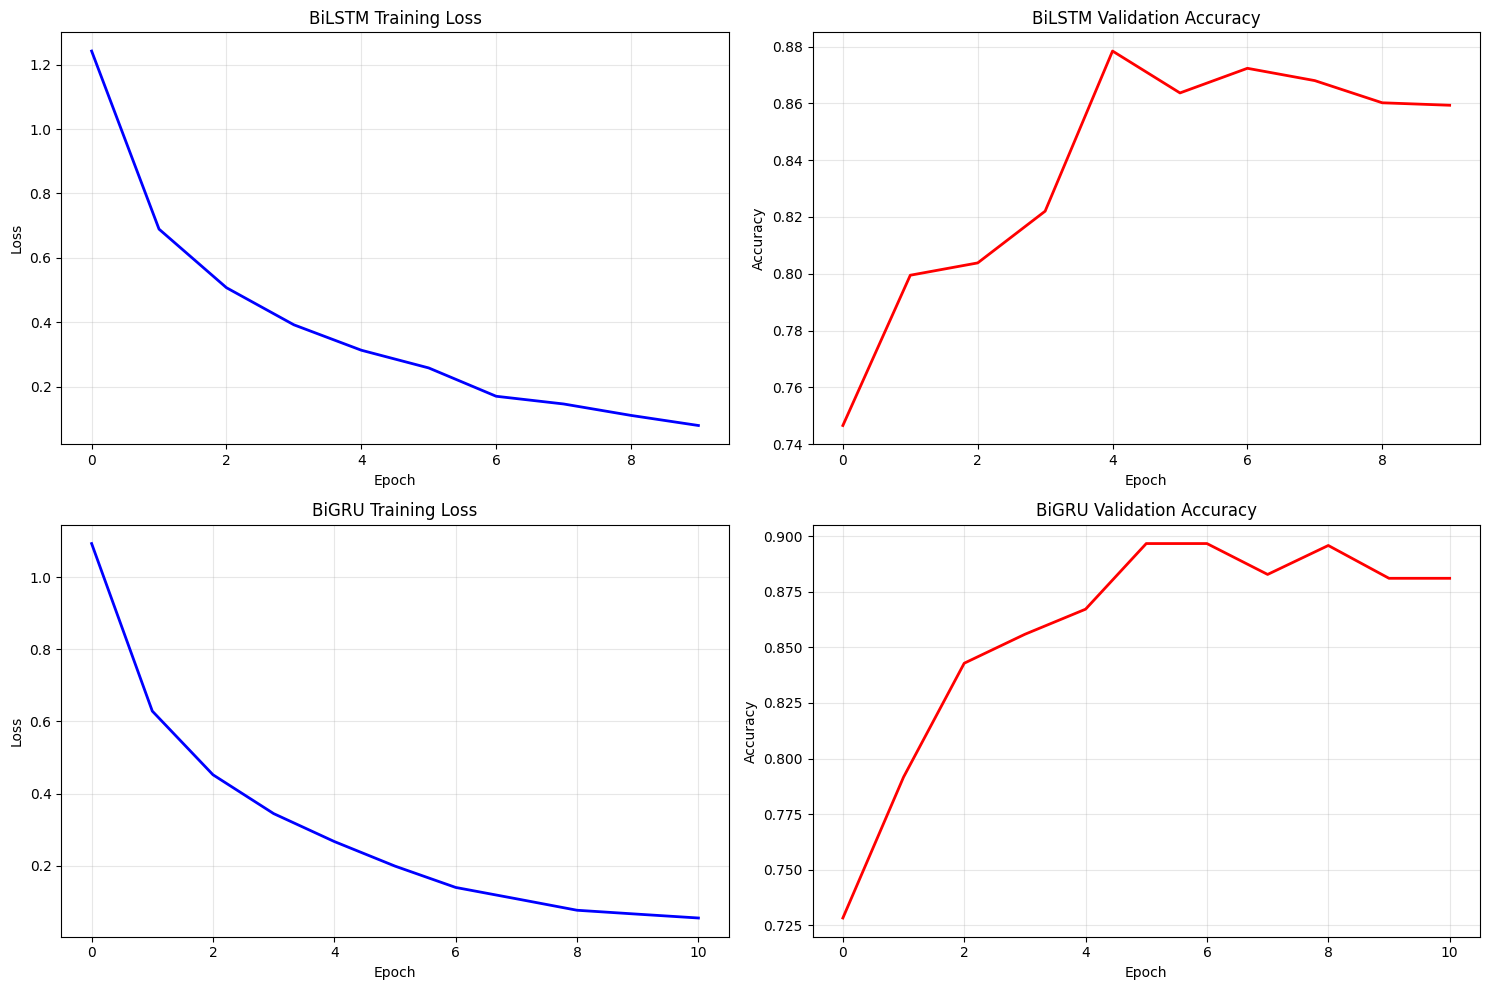

BiLSTM Test Accuracy: 0.8894
BiGRU Test Accuracy: 0.9055


In [58]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(train_losses_bilstm, 'b-', linewidth=2)
axes[0, 0].set_title('BiLSTM Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(valid_accs_bilstm, 'r-', linewidth=2)
axes[0, 1].set_title('BiLSTM Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(train_losses_bigru, 'b-', linewidth=2)
axes[1, 0].set_title('BiGRU Training Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(valid_accs_bigru, 'r-', linewidth=2)
axes[1, 1].set_title('BiGRU Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bilstm_bigru_curves.png', dpi=300)
plt.show()

print(f"BiLSTM Test Accuracy: {test_acc_bilstm:.4f}")
print(f"BiGRU Test Accuracy: {test_acc_bigru:.4f}")

### Part 3.2: CNN Model

In [59]:
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes,
                 output_dim, dropout, embedding_matrix):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))

        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, n_filters, fs)
            for fs in filter_sizes
        ])

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.filter_sizes = filter_sizes

    def forward(self, text, text_lengths):
        text = text.permute(1, 0)

        embedded = self.embedding(text)  # [batch, seq_len, emb_dim]
        embedded = embedded.permute(0, 2, 1)  # [batch, emb_dim, seq_len] for Conv1d

        conved_list = []
        for conv, filter_size in zip(self.convs, self.filter_sizes):
            if embedded.size(2) >= filter_size:
                conv_out = torch.relu(conv(embedded))
                pooled = torch.max(conv_out, dim=2)[0]
            else:
                pooled = torch.zeros(embedded.size(0), conv.out_channels, device=embedded.device)
            conved_list.append(pooled)

        cat = self.dropout(torch.cat(conved_list, dim=1))
        return self.fc(cat)

In [69]:
# CNN
N_FILTERS = 100
FILTER_SIZES = [2, 3, 4, 5]

cnn = CNNClassifier(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES,
                    OUTPUT_DIM, dropout=0.5, embedding_matrix=embedding_matrix).to(device)

optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

best_valid_acc = 0
patience_counter = 0
train_losses_cnn = []
valid_accs_cnn = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_epoch(cnn, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(cnn, valid_iterator, criterion)

    train_losses_cnn.append(train_loss)
    valid_accs_cnn.append(valid_acc)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        patience_counter = 0
        torch.save(cnn.state_dict(), 'cnn.pt')
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        break

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Valid Acc={valid_acc:.3f}")

cnn.load_state_dict(torch.load('cnn.pt'))
_, test_acc_cnn = evaluate(cnn, test_iterator, criterion)
print(f"CNN Test Accuracy: {test_acc_cnn:.4f}\n")

Epoch 5: Valid Acc=0.880
Epoch 10: Valid Acc=0.889
CNN Test Accuracy: 0.9050



### Question 3(b): CNN Results

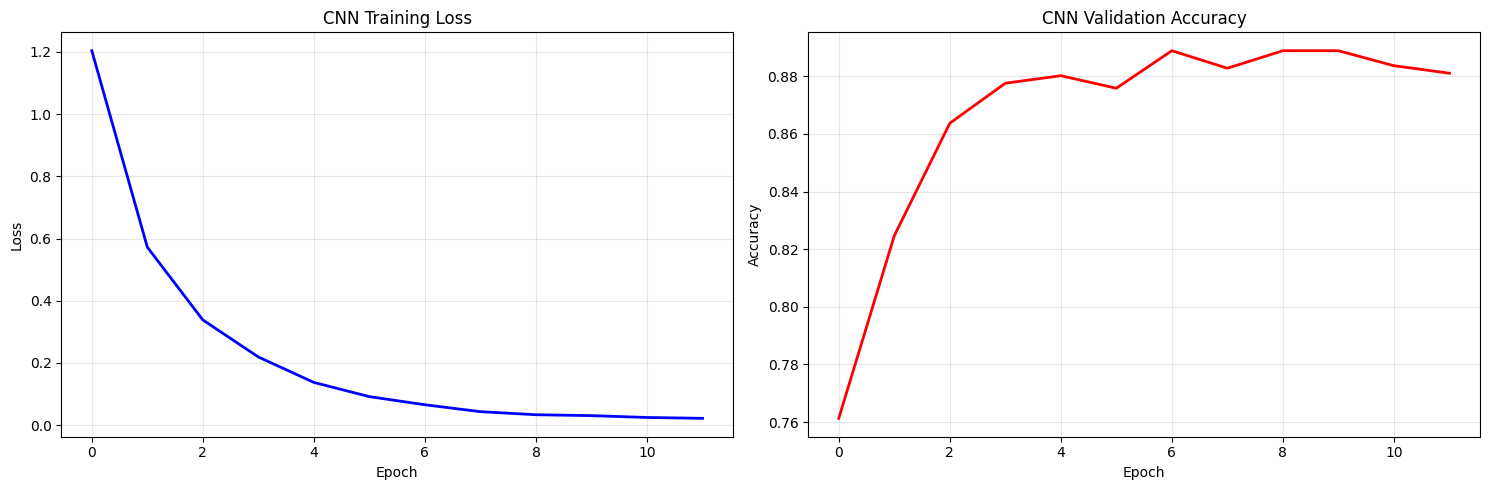

CNN Test Accuracy: 0.9050


In [72]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses_cnn, 'b-', linewidth=2)
axes[0].set_title('CNN Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(valid_accs_cnn, 'r-', linewidth=2)
axes[1].set_title('CNN Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cnn_curves.png', dpi=300)
plt.show()

print(f"CNN Test Accuracy: {test_acc_cnn:.4f}")

### Part 3.3: Ensemble Model

In [62]:
class BiGRU_CNN_Ensemble(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        n_filters,
        filter_sizes,
        output_dim,
        dropout,
        embedding_matrix=None,
        pad_idx=None,
        use_mean_pool=False
    ):
        super().__init__()

        # Embedding
        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim,
            padding_idx=pad_idx if pad_idx is not None else 0
        )

        if embedding_matrix is not None:
            if isinstance(embedding_matrix, torch.Tensor):
                emb_t = embedding_matrix
            else:
                emb_t = torch.from_numpy(embedding_matrix)
            self.embedding.weight.data[:emb_t.size(0), :emb_t.size(1)].copy_(emb_t)

        if pad_idx is not None:
            with torch.no_grad():
                self.embedding.weight.data[pad_idx].zero_()

        # BiGRU
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            bidirectional=True,
            dropout=dropout,
            batch_first=False
        )
        self.use_mean_pool = use_mean_pool
        self.gru_dropout = nn.Dropout(dropout)

        # CNN tower
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=n_filters,
                kernel_size=fs,
                padding=fs // 2
            )
            for fs in filter_sizes
        ])
        self.cnn_dropout = nn.Dropout(dropout)

        # concat + MLP
        gru_out_dim  = hidden_dim * 2 # bi-directional
        cnn_out_dim  = n_filters * len(filter_sizes)
        fused_dim    = gru_out_dim + cnn_out_dim

        self.fc = nn.Sequential(
            nn.Linear(fused_dim, max(128, fused_dim // 2)),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(max(128, fused_dim // 2), output_dim)
        )

        self.pad_idx = 0 if pad_idx is None else pad_idx
        self.min_length = max(filter_sizes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        """
        text: LongTensor [seq_len, batch]
        text_lengths: 1D LongTensor [batch], on CPU for packing
        """
        # Shared embeddings
        embedded = self.dropout(self.embedding(text))# [seq, batch, emb]

        # GRU path
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), batch_first=False, enforce_sorted=False
        )
        packed_out, hidden = self.gru(packed)
        # hidden: [num_layers*2, batch, hidden]
        if self.use_mean_pool:
            unpacked, lengths = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=False)

            mask = torch.arange(unpacked.size(0), device=unpacked.device)[:, None] < lengths[None, :]
            mask = mask.float().unsqueeze(-1)
            summed = (unpacked * mask).sum(dim=0) # [batch, 2*hidden]
            denom = lengths.clamp_min(1).float().unsqueeze(-1)
            gru_out = summed / denom
        else:
            # concat last forward/backward states from top layer
            gru_out = torch.cat((hidden[-2], hidden[-1]), dim=1) # [batch, 2*hidden]

        gru_out = self.gru_dropout(gru_out)

        # CNN path
        text_bxT = text.permute(1, 0) # [batch, seq]
        if text_bxT.size(1) < self.min_length:
            pad_len = self.min_length - text_bxT.size(1)
            pad_tokens = torch.full(
                (text_bxT.size(0), pad_len),
                fill_value=self.pad_idx,
                dtype=text_bxT.dtype,
                device=text_bxT.device
            )
            text_bxT = torch.cat([text_bxT, pad_tokens], dim=1)

        emb_cnn = self.embedding(text_bxT) # [batch, seq, emb]
        x = emb_cnn.transpose(1, 2) # [batch, emb, seq]

        conv_feats = []
        for conv in self.convs:
            c = conv(x) # [batch, n_filters, seq]
            c = F.relu(c, inplace=True)
            c = F.max_pool1d(c, kernel_size=c.size(2)).squeeze(2) # [batch, n_filters]
            conv_feats.append(c)
        cnn_out = torch.cat(conv_feats, dim=1) # [batch, n_filters*len(fs)]
        cnn_out = self.cnn_dropout(cnn_out)

        fused = torch.cat([gru_out, cnn_out], dim=1) # [batch, fused_dim]
        fused = self.dropout(fused)
        logits = self.fc(fused) # [batch, output_dim]
        return logits

In [63]:
import torch.nn.functional as F
# BiGRU + CNN Ensemble
print("Training BiGRU + CNN Ensemble")
ensemble = BiGRU_CNN_Ensemble(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM,
                               N_FILTERS, FILTER_SIZES, OUTPUT_DIM,
                               dropout=0.5, embedding_matrix=embedding_matrix).to(device)

optimizer = optim.Adam(ensemble.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

best_valid_acc = 0
patience_counter = 0
train_losses_ensemble2 = []
valid_accs_ensemble2 = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_epoch(ensemble, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(ensemble, valid_iterator, criterion)

    train_losses_ensemble2.append(train_loss)
    valid_accs_ensemble2.append(valid_acc)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        patience_counter = 0
        torch.save(ensemble.state_dict(), 'bigru_cnn_ensemble.pt')
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        break

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Valid Acc={valid_acc:.3f}")

ensemble.load_state_dict(torch.load('bigru_cnn_ensemble.pt'))
_, test_acc_bigrucnn_ensemble = evaluate(ensemble, test_iterator, criterion)
print(f"\nBiGRU + CNN Ensemble Test Accuracy: {test_acc_bigrucnn_ensemble:.4f}")

Training BiGRU + CNN Ensemble
Epoch 5: Valid Acc=0.891
Epoch 10: Valid Acc=0.897

BiGRU + CNN Ensemble Test Accuracy: 0.9114


### Question 3(c): Ensemble Results

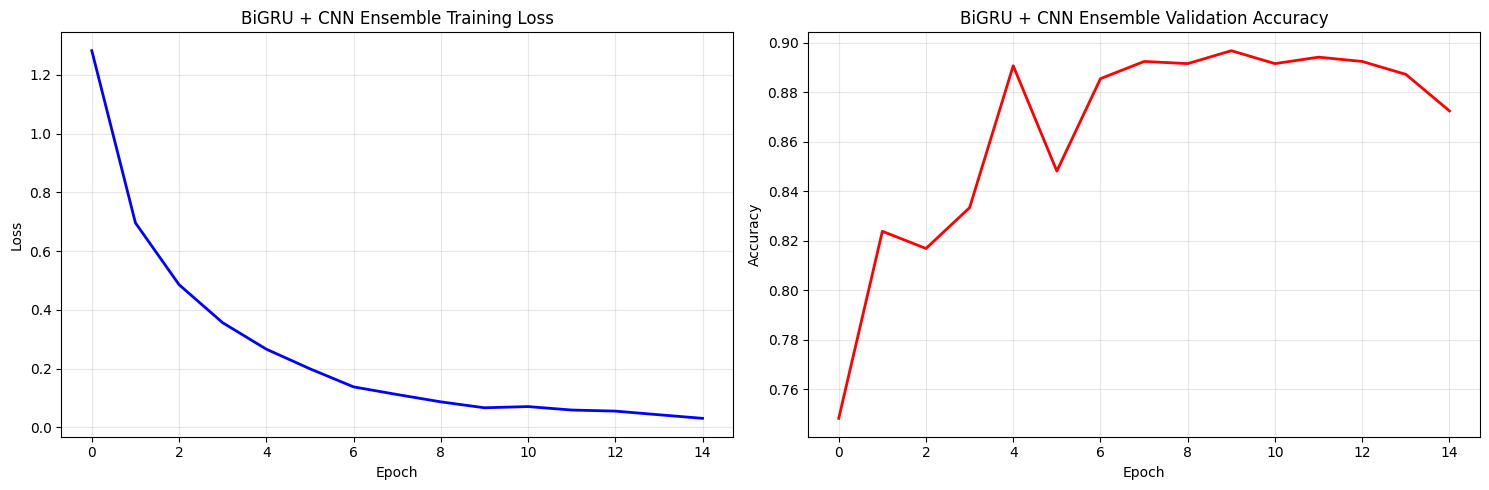

BiGRU + CNN Ensemble Test Accuracy: 0.9114


In [64]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses_ensemble2, 'b-', linewidth=2)
axes[0].set_title('BiGRU + CNN Ensemble Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(valid_accs_ensemble2, 'r-', linewidth=2)
axes[1].set_title('BiGRU + CNN Ensemble Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bigru_cnn_ensemble_curves.png', dpi=300)
plt.show()

print(f"BiGRU + CNN Ensemble Test Accuracy: {test_acc_bigrucnn_ensemble:.4f}")

### Part 3.4: Targeted Improvement for Weak Topics

In [65]:
# Calculate class weights
class_counts = Counter()
for example in train_data.examples:
    class_counts[example.label] += 1

total = sum(class_counts.values())
num_classes = len(class_counts)
class_weights = torch.zeros(num_classes)

for label, count in class_counts.items():
    label_idx = LABEL.vocab.stoi[label]
    class_weights[label_idx] = total / (num_classes * count)

class_weights = class_weights.to(device)

print("Class-weighted loss to focus on minority classes")
print("\nClass weights:")
for i, label in enumerate(LABEL.vocab.itos):
    print(f"  {label}: {class_weights[i]:.4f}")

Class-weighted loss to focus on minority classes

Class weights:
  HUM: 0.7270
  ENTY: 0.7388
  DESC: 0.8024
  NUM: 0.9838
  LOC: 1.0900
  ABBR: 11.0152


In [66]:
# Train with class weights
print("BiLSTM with Class-Weighted Loss")
weighted_model = BiLSTMClassifier(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                                  N_LAYERS, dropout=0.5,
                                  embedding_matrix=embedding_matrix).to(device)

optimizer = optim.Adam(weighted_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)

best_valid_acc = 0
patience_counter = 0

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_epoch(weighted_model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(weighted_model, valid_iterator, criterion)

    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        patience_counter = 0
        torch.save(weighted_model.state_dict(), 'weighted.pt')
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        break

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Valid Acc={valid_acc:.3f}")

weighted_model.load_state_dict(torch.load('weighted.pt'))
_, test_acc_weighted = evaluate(weighted_model, test_iterator, criterion)
print(f"Weighted Model Test Accuracy: {test_acc_weighted:.4f}\n")

BiLSTM with Class-Weighted Loss
Epoch 5: Valid Acc=0.841
Epoch 10: Valid Acc=0.859
Weighted Model Test Accuracy: 0.8870



### Question 3(d): Topic-wise Comparison

topic wise comparison:
Topic           RNN             Weighted        Improvement
DESC            0.9710          0.9493          -0.0217
ENTY            0.8298          0.6915          -0.1383
ABBR            0.7778          0.7778          +0.0000
HUM             0.9077          0.8923          -0.0154
LOC             0.8519          0.9506          +0.0988
NUM             0.8850          0.9381          +0.0531


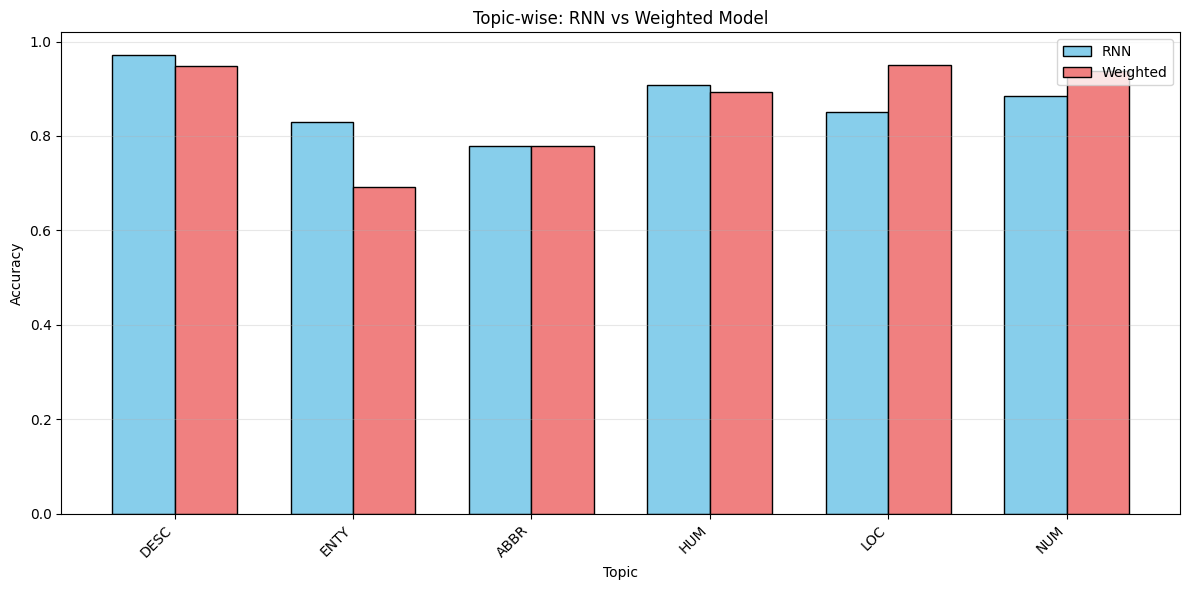

In [73]:
topic_accuracy_weighted = evaluate_topic_wise(weighted_model, test_iterator, LABEL.vocab)

print("topic wise comparison:")
print(f"{'Topic':<15} {'RNN':<15} {'Weighted':<15} {'Improvement'}")

for topic in topic_accuracy_rnn.keys():
    rnn_acc = topic_accuracy_rnn[topic]
    weighted_acc = topic_accuracy_weighted[topic]
    improvement = weighted_acc - rnn_acc
    print(f"{topic:<15} {rnn_acc:<15.4f} {weighted_acc:<15.4f} {improvement:+.4f}")

# Visualize
topics = list(topic_accuracy_rnn.keys())
rnn_accs = [topic_accuracy_rnn[t] for t in topics]
weighted_accs = [topic_accuracy_weighted[t] for t in topics]

x = np.arange(len(topics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, rnn_accs, width, label='RNN', color='skyblue', edgecolor='black')
ax.bar(x + width/2, weighted_accs, width, label='Weighted', color='lightcoral', edgecolor='black')

ax.set_xlabel('Topic')
ax.set_ylabel('Accuracy')
ax.set_title('Topic-wise: RNN vs Weighted Model')
ax.set_xticks(x)
ax.set_xticklabels(topics, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('topic_comparison.png', dpi=300)
plt.show()

## Final Summary

RNN                 : 0.9153 (91.53%)
Ensemble            : 0.9114 (91.14%)
BiGRU               : 0.9055 (90.55%)
CNN                 : 0.9050 (90.50%)
BiLSTM              : 0.8894 (88.94%)
Weighted            : 0.8870 (88.70%)


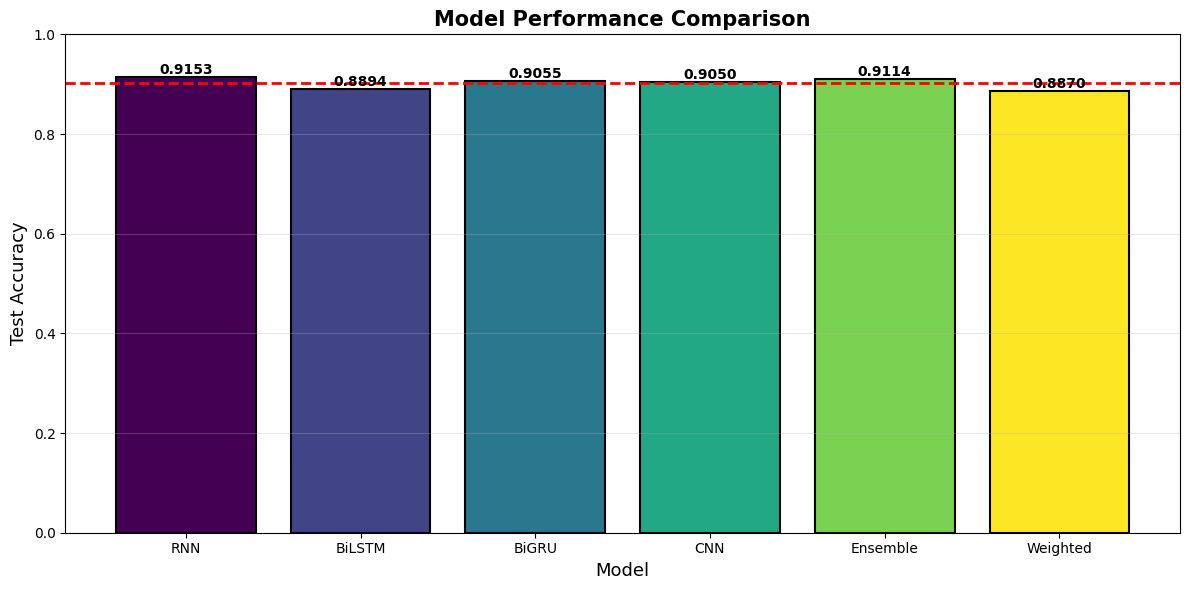

In [74]:
all_results = {
    'RNN': regularization_results['Dropout + L2'],
    'BiLSTM': test_acc_bilstm,
    'BiGRU': test_acc_bigru,
    'CNN': test_acc_cnn,
    'Ensemble': test_acc_bigrucnn_ensemble,
    'Weighted': test_acc_weighted
}

for model, acc in sorted(all_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model:<20s}: {acc:.4f} ({acc*100:.2f}%)")

# Visualization
plt.figure(figsize=(12, 6))
models = list(all_results.keys())
accuracies = list(all_results.values())
colors = plt.cm.viridis(np.linspace(0, 1, len(models)))

bars = plt.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.5)
plt.xlabel('Model', fontsize=13)
plt.ylabel('Test Accuracy', fontsize=13)
plt.title('Model Performance Comparison', fontsize=15, fontweight='bold')
plt.ylim([0, 1.0])
plt.axhline(y=np.mean(accuracies), color='red', linestyle='--', linewidth=2)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('final_comparison.png', dpi=300)
plt.show()